In [ ]:
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install seaborn
%pip install scikit-learn
%pip install dotenv
%pip install libsql
%pip install imblearn
%pip install libsql-client


In [37]:
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import os
from libsql_client import create_client
import libsql
import json
import ast

load_dotenv()

True

In [ ]:
print("Connecting to the database...")


url = os.getenv("TURSO_DATABASE_URL")
auth_token = os.getenv("TURSO_AUTH_TOKEN")

conn = libsql.connect("hello.db", sync_url=url, auth_token=auth_token) # type: ignore
conn.sync()


Connecting to the database...


In [ ]:
def fetch_data(conn,query):
    """
    Fetch data from the database using the provided query.
    """
    try:
        result = conn.execute(query).fetchall()
        columns = [desc[0] for desc in conn.execute(query).description]
        embedding_status = pd.DataFrame(result, columns=columns)
        return embedding_status
    except Exception as e:
        print(f"Error fetching data: {e}")
        return pd.DataFrame()

In [ ]:
from email.mime import application


query_embedding = """
select *
from embedded_application
"""

embedding = fetch_data(conn, query_embedding)


query_application_status = """
select * 
from application_status
"""

application_status = fetch_data(conn, query_application_status)



embedding_status = pd.merge(embedding, application_status, left_on="application_id",right_on="id", how="left")
embedding_status = embedding_status[["company_and_application_embedding","status"]]
embedding_status["status"] = embedding_status["status"].apply(lambda x: 1 if x in ["ACCEPTED","SELECTED","HIRED","FINISHED"] else 0)


0           REJECTED
2           FINISHED
3              HIRED
10    IN_APPLICATION
26          ACCEPTED
77          SELECTED
79         SUBMITTED
Name: status, dtype: object


In [ ]:

# Paso 1: Elimina saltos de línea y parsea la string como lista
embedding_status['parsed_embedding'] = embedding_status['company_and_application_embedding'].apply(
    lambda x: ast.literal_eval(x.replace('\n', '').strip())
)

# Paso 2: Verifica el resultado



0    [0.0017217881977558136, -0.004764638841152191,...
1    [-0.015603585168719292, -0.005204336252063513,...
2    [0.0006741584511473775, 0.003050131257623434, ...
3    [-0.0026647576596587896, -0.003319757059216499...
4    [-0.0019240669207647443, 0.0025208976585417986...
Name: parsed_embedding, dtype: object


# Pipeline de entrenamiento

🔎 Mejores parámetros: {'clf__max_depth': 5, 'clf__max_features': 'sqrt', 'clf__min_samples_split': 5, 'clf__n_estimators': 50}
⭐ Mejor precisión CV (clase 1): 0.6527
Precision en test (clase 1): 0.5000
              precision    recall  f1-score   support

           0       0.91      0.77      0.83        13
           1       0.50      0.75      0.60         4

    accuracy                           0.76        17
   macro avg       0.70      0.76      0.72        17
weighted avg       0.81      0.76      0.78        17



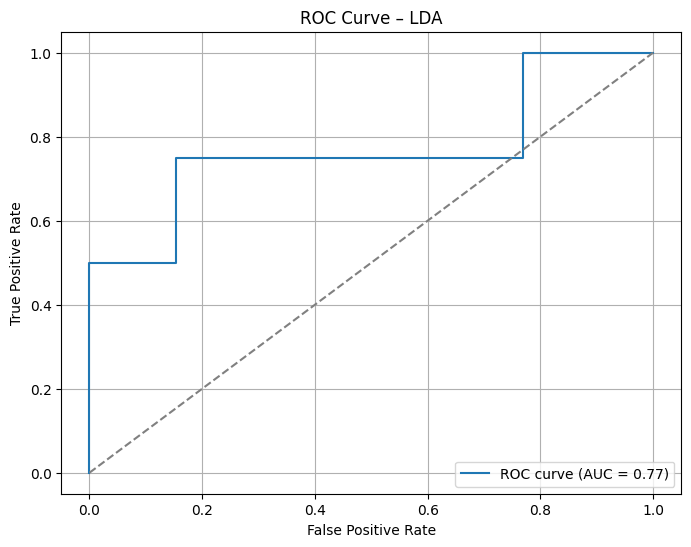

🔧 Mejor threshold según Accuracy: 0.69
📈 Accuracy con threshold óptimo: 0.8824
Precision (threshold 0.69): 1.0000
              precision    recall  f1-score   support

           0       0.87      1.00      0.93        13
           1       1.00      0.50      0.67         4

    accuracy                           0.88        17
   macro avg       0.93      0.75      0.80        17
weighted avg       0.90      0.88      0.87        17



In [45]:
from random import Random
from re import X
import matplotlib.pyplot as plt
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    make_scorer,
    precision_score,
    roc_auc_score,
    roc_curve,
    accuracy_score,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler

X = np.array(embedding_status['parsed_embedding'].tolist())
y = np.array(embedding_status['status'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline = Pipeline(
    [
        ("smote", SMOTE(random_state=42)),
        ("clf",RandomForestClassifier(random_state=42, n_jobs=-1, class_weight="balanced", max_depth=10, n_estimators=100))
    ]
)

param_grid = {
    "clf__n_estimators": [50, 100, 200],
    "clf__max_depth": [5, 10, 20],
    "clf__max_features": ["sqrt", "log2"],
    "clf__min_samples_split": [2, 5, 10],
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring="accuracy",
    cv=5,
    n_jobs=-1,
    verbose=0,
)
grid_search.fit(X_train, y_train)

# 7) Resultados
print("🔎 Mejores parámetros:", grid_search.best_params_)  # noqa: T201
print(f"⭐ Mejor precisión CV (clase 1): {grid_search.best_score_:.4f}")  # noqa: T201

best_model = grid_search.best_estimator_
# 8) Evaluación en test

y_pred = best_model.predict(X_test)
prec_test = precision_score(y_test, y_pred, pos_label=1)
print(f"Precision en test (clase 1): {prec_test:.4f}")  # noqa: T201
print(classification_report(y_test, y_pred))  # noqa: T201

# 9) Curva ROC y AUC
y_prob = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.2f})")
plt.plot([0,1],[0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – LDA")  # noqa: RUF001
plt.legend(loc="lower right")
plt.grid(True)  # noqa: FBT003
plt.show()

# 10) Umbral óptimo según Accuracy  # noqa: RUF003
accuracies = []
for thr in thresholds:
    y_pred_thr = (y_prob >= thr).astype(int)
    acc = accuracy_score(y_test, y_pred_thr)
    accuracies.append(acc)
best_threshold = thresholds[np.argmax(accuracies)]
best_accuracy = max(accuracies)
print(f"🔧 Mejor threshold según Accuracy: {best_threshold:.2f}")  # noqa: T201
print(f"📈 Accuracy con threshold óptimo: {best_accuracy:.4f}")  # noqa: T201

# 11) Evaluación con threshold personalizado
y_pred_custom = (y_prob >= best_threshold).astype(int)
prec_custom = precision_score(y_test, y_pred_custom, pos_label=1)
print(f"Precision (threshold {best_threshold:.2f}): {prec_custom:.4f}")  # noqa: T201
print(classification_report(y_test, y_pred_custom))  # noqa: T201